<a href="https://colab.research.google.com/github/philipp-lampert/mymandible/blob/main/data_science/02_data_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is the data exploration and visualization notebook

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Let's first import the processed dataframe from GitHub.

In [ ]:
local_directory = "/root/mymandible"
%cd

if os.path.exists(local_directory):
  os.chdir(local_directory)
  ! git pull
  %cd data_science/data

else:
  ! git clone https://github.com/philipp-lampert/mymandible
  %cd mymandible/data_science/data

df = pd.read_parquet('mymandible.parquet')

/root
Already up to date.
/root/mymandible/data_science/data


We will start by creating some graphs to get a sense of what our patient collective looks like.

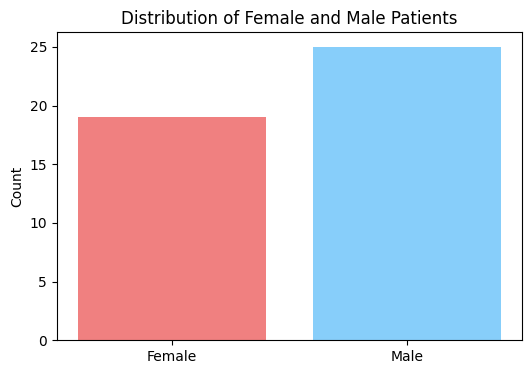

In [ ]:
female_count = df['sex_female'].sum()
male_count = len(df) - female_count

labels = ['Female', 'Male']
sizes = [female_count, male_count]
colors = ['lightcoral', 'lightskyblue']

plt.figure(figsize=(6, 4))
plt.bar(labels, [female_count, male_count], color=colors)
plt.title('Distribution of Female and Male Patients')
plt.ylabel('Count')
plt.show()

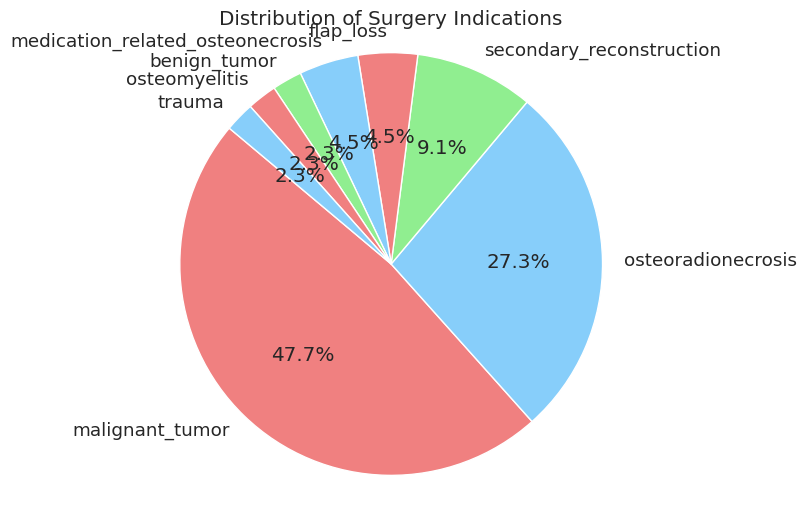

In [ ]:
indication_counts = df['indication'].value_counts()

labels = indication_counts.index
sizes = indication_counts.values
colors = ['lightcoral', 'lightskyblue', 'lightgreen']  # You can add more colors for different indications

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Surgery Indications')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()

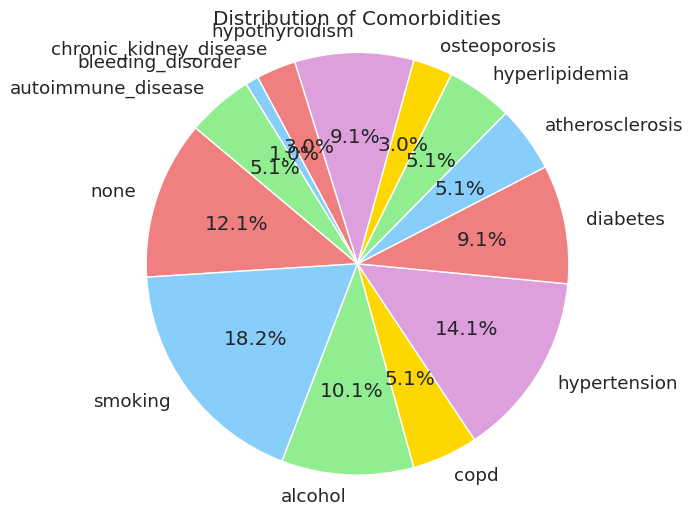

In [ ]:
comorbidity_counts = {}

# Calculate counts for comorbidity columns
for column in df.columns:
    if "comorbidity___" in column:
        comorbidity_option = column.replace('comorbidity___', '')
        count = df[column].sum()
        comorbidity_counts[comorbidity_option] = count

# Create a pie chart
labels = comorbidity_counts.keys()
sizes = comorbidity_counts.values()
colors = ['lightcoral', 'lightskyblue', 'lightgreen', 'gold', 'plum']

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Comorbidities')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.
plt.show()